# Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps

https://proceedings.mlr.press/v202/cuturi23a.html

In [25]:
import jax
import jax.numpy as jnp
from jax import lax 
from jax import vmap

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from tqdm import tqdm

#### Monge Optimal Transport Problem

We consider a translation-invariant cost function $c(x,y) := h(x-y)$ where $h : \mathbb{R}^{d} \longrightarrow \mathbb{R}$. The Monge problem is the following optimisation problem :
$$ T^{*} := \arg\limits_{T \sharp \mu = \nu} \inf { \int_{\mathbb{R}^{d}} h(x - T(x)) d\mu(x) } $$
With $\forall A \subset \mathbb{R}^{d}, \: T \sharp \mu(A) = \mu(T^{-1}(A))$ 

In our case, we will consider $h$ of elastic type with the following form : $\forall z \in \mathbb{R}^{d}, \: h(z) := \frac{1}{2} \|z\|^2 + \tau(z)$ where $\tau$ is a function whose proximal operator is well defined. 

The aim of the paper is to establish a consistant estimator $T_{h,\varepsilon}$ of $T^{*}$. In this tutorial, we will restrict ourself to the following functions $\tau$ which are pretty simple and implemented (with their gradient, proximal operator, ...) optimally in OTT JAX :

1) Euclidian Case without any regularization : $\tau(z) = 0$, associated cost function $h$ will be `SqEuclidean`

2) $\ell_1$ regularization : $\tau(z) = \gamma \| z \|_{1}$, associated cost function $h$ will be `ElasticL1`

3) Soft Thresholding Vanishing Shrinkage (STVS) : $\tau(z) = \gamma^{2} \mathbf{1}_{d}^{T}\left( \text{asinh}(\frac{z}{2\gamma}) + \frac{1}{2} - \frac{1}{2}e^{-2\text{asinh}(\frac{z}{2\gamma})} \right)$, associated cost function $h$ will be `ElasticSTVS`

4) $k-$ Overlap : $\tau(z) = \| z \|_{\text{ov}k}$, associated cost function $h$ will be `ElasticSqKOverlap`

##### In this tutorial, we wanted to explain some functions of OTT JAX and to illustrate this, we wanted to reproduce the Synthetic experiments in the case of Constant sparsity-pattern and x-dependent sparcity pattern which has been studied in the article

We consider the following distributions: 

- $ \mu = \mathcal{U}_{[0,1]^d}$ ;
- For an integer $ s<d $, we set $ \nu = T^\star_s \sharp \mu \, , \, T^\star_s(x) = [\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d] $ where the map $ T^\star_s $ acts on coordinates independently.
- 

We then generate $n$ i.i.d. samples $x_i$ from $\mu$, and $y_j$ from $\nu$ independently. The samples $y_j$ are obtained by first generating fresh i.i.d. samples $\tilde{x}_j$ from $\mu$ and then pushing them: $y_j := T^\star_s(\tilde{x}_j)$.

In [4]:
def map_constant_pattern(X,s) : 
    return jnp.concatenate((jnp.exp(X[:,:s]), X[:,s:]),-1)

#def map_constant_pattern(X, s):
#    X = jnp.apply_along_axis(lambda x: jnp.concatenate([jnp.exp(x[:s]), x[s:]]) , axis=1, arr=X)
#    return X

def map_dependent_pattern(x, s):
    n1 = jnp.sum(x[:s]**2)
    n2 = jnp.sum(x[s:(2*s)]**2)

    print(n1)
    print(n2)

    
    if n1 > n2:
        return jnp.concatenate(( jnp.exp(x[:,:s]), x[:,s:]),-1)
        
    else:
        return jnp.concatenate(( x[:,:s], jnp.exp(x[:,s:2*s]), x[:,2*s:]),-1)

In [5]:
map_constant_pattern(jnp.array([[1,2,3,4],[1,2,3,4]]),2)

Array([[2.7182817, 7.389056 , 3.       , 4.       ],
       [2.7182817, 7.389056 , 3.       , 4.       ]], dtype=float32)

In [6]:
map_dependent_pattern(jnp.array([[1,2,3,4],[1,2,3,4]]),2)

60
0


Array([[2.7182817, 7.389056 , 3.       , 4.       ],
       [2.7182817, 7.389056 , 3.       , 4.       ]], dtype=float32)

In [7]:
def uniform_samples(n, d, key):
   return(jnp.asarray(jax.random.uniform(key,(n,d))))


def sample_data(n, d, s, type_transport):
   key=jax.random.PRNGKey(0)
   key_1, key_2 = jax.random.split(key)

   X = uniform_samples(n,d,key_1)
   X_tilde = uniform_samples(n,d,key_2)

   if type_transport == "constant_pattern" :
      T_star = map_constant_pattern(X, s)
      Y = map_constant_pattern(X_tilde, s)

   else : 
      T_star = map_dependent_pattern(X, s)
      Y = map_dependent_pattern(X_tilde, s)
   return(X, T_star, Y)


In [8]:
n = 1000
d = 100
s=5

X, T_star, Y = sample_data(n, d, s, "constant_pattern")

print(X.shape, T_star.shape, Y.shape)


(1000, 100) (1000, 100) (1000, 100)


In [10]:
def run_experiment(X, Y, cost):

    geom = ott.geometry.pointcloud.PointCloud(X, Y, cost_fn=cost)

    ot_prob = linear_problem.LinearProblem(geom)

    solver = sinkhorn.Sinkhorn()
    
    ot = solver(ot_prob)

    dual_potentials = ot.to_dual_potentials()

    return dual_potentials.transport(X)


In [28]:
def normalized_mse(y, y_pred) :
    return  (1/y.shape[1]) * jnp.mean(jnp.linalg.norm(y-y_pred,axis=1)**2)
    
def support_error(y_pred,x) :
    delta = y_pred -x
    return jnp.mean(jnp.sum(delta[:,s+1:]**2,axis=1) / (jnp.sum(delta**2,axis=1)))

In [ ]:
cost_L2 = ott.geometry.costs.PNormP(2)
cost_STVS = ott.geometry.costs.ElasticSTVS(scaling_reg=gamma, matrix=None, orthogonal=False)
cost_L1= ott.geometry.costs.ElasticL1(scaling_reg=gamma, matrix=None, orthogonal=False)

In [58]:
def compute_metrics(costs, n, d, s):
    all_msse = []
    all_support_errors = []

    for cost in tqdm(costs):
        X, T_star, Y = sample_data(n, d, s, "constant_pattern")
        transport = run_experiment(X, Y, cost)

        msse = normalized_mse(T_star, transport)
        all_msse.append(msse)

        error = support_error(transport,X)
        all_support_errors.append(error)

    return(all_msse,all_support_errors)

In [46]:
gammas = sorted([10**(j) * i for i in range(1,10) for j in range(-2,2)])

costs_L1 = [ott.geometry.costs.ElasticL1(scaling_reg=gamma, matrix=None, orthogonal=False) for gamma in gammas]
costs_STVS = [ott.geometry.costs.ElasticSTVS(scaling_reg=gamma, matrix=None, orthogonal=False) for gamma in gammas]
costs_L2 = [ott.geometry.costs.PNormP(2) for gamma in gammas]
costs_ovk_7 = [ott.geometry.costs.ElasticSqKOverlap(7, scaling_reg=gamma) for gamma in gammas]
costs_ovk_5 = [ott.geometry.costs.ElasticSqKOverlap(5, scaling_reg=gamma) for gamma in gammas]

In [59]:
n = 1000
d = 8
s=5

msse_L1_d_8, support_errors_L1_d_8 = compute_metrics(costs_L1, n, d, s)
msse_STVS_d_8, support_errors_STVS_d_8 = compute_metrics(costs_STVS, n, d, s)
msse_L2_d_8, support_errors_L2_d_8 = compute_metrics(costs_L2, n, d, s)
msse_ovk_7_d_8, support_errors_ovk_7_d_8 = compute_metrics(costs_ovk_7, n, d, s)
msse_ovk_5_d_8, support_errors_ovk_5_d_8 = compute_metrics(costs_ovk_5, n, d, s)

100%|██████████| 36/36 [01:30<00:00,  2.51s/it]


In [30]:
n = 1000
d = 20
s=5

msse_L1_d_20, support_errors_L1_d_20 = compute_metrics(costs_L1, n, d, s)
msse_STVS_d_20, support_errors_STVS_d_20 = compute_metrics(costs_STVS, n, d, s)
msse_L2_d_20, support_errors_L2_d_20 = compute_metrics(costs_L2, n, d, s)
msse_ovk_7_d_20, support_errors_ovk_7_d_20 = compute_metrics(costs_ovk_7, n, d, s)
msse_ovk_5_d_20, support_errors_ovk_5_d_20 = compute_metrics(costs_ovk_5, n, d, s)


100%|██████████| 36/36 [02:33<00:00,  4.27s/it]


In [ ]:
n = 1000
d = 100
s=5

msse_L1_d_100, support_errors_L1_d_100 = compute_metrics(costs_L1, n, d, s)
msse_STVS_d_100, support_errors_STVS_d_100 = compute_metrics(costs_STVS, n, d, s)
msse_L2_d_100, support_errors_L2_d_100 = compute_metrics(costs_L2, n, d, s)
msse_ovk_7_d_100, support_errors_ovk_7_d_100 = compute_metrics(costs_ovk_7, n, d, s)
msse_ovk_5_d_100, support_errors_ovk_5_d_100 = compute_metrics(costs_ovk_5, n, d, s)

In [52]:
support_errors_L2_d_20

NameError: name 'support_errors_L2_d_20' is not defined

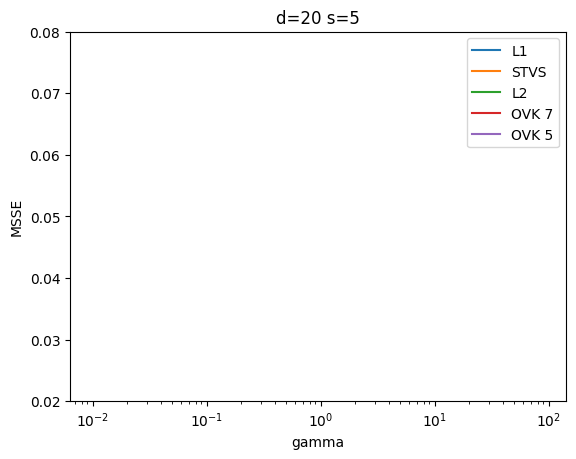

In [61]:
plt.plot(gammas, support_errors_L1_d_8, label='L1')
plt.plot(gammas, support_errors_STVS_d_8, label='STVS')
plt.plot(gammas, support_errors_L2_d_8, label='L2')
plt.plot(gammas, support_errors_ovk_7_d_8, label='OVK 7')
plt.plot(gammas, support_errors_ovk_5_d_8, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('MSSE')
plt.xscale('log')
plt.ylim(0.02,0.08)
plt.title('d=20 s=5')
plt.legend()

plt.show()

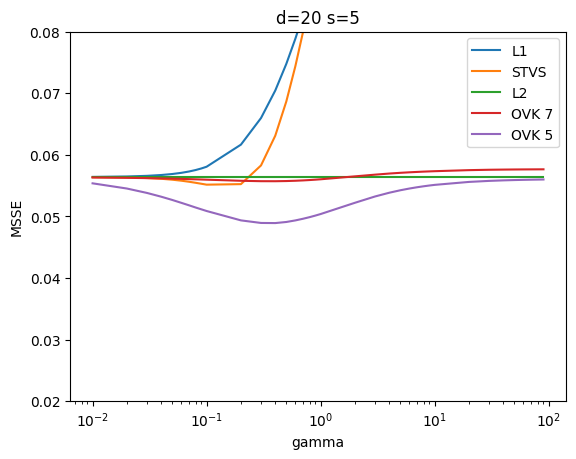

In [49]:
plt.plot(gammas, msse_L1, label='L1')
plt.plot(gammas, msse_STVS, label='STVS')
plt.plot(gammas, msse_L2, label='L2')
plt.plot(gammas, msse_ovk_7, label='OVK 7')
plt.plot(gammas, msse_ovk_5, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('MSSE')
plt.xscale('log')
plt.ylim(0.02,0.08)
plt.title('d=20 s=5')
plt.legend()


plt.show()

In [ ]:
plt.plot(gammas, msse_L1, label='L1')
plt.plot(gammas, msse_STVS, label='STVS')
plt.plot(gammas, msse_L2, label='L2')
plt.plot(gammas, msse_ovk_7, label='OVK 7')
plt.plot(gammas, msse_ovk_5, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('MSSE')
plt.xscale('log')
plt.ylim(0.02,0.08)
plt.title('d=20 s=5')
plt.legend()


plt.show()

In [ ]:
print(samples_Y)
jnp.sum(jnp.square(Y-transport))

[[0.03902256 0.61041987 0.18761909 ... 0.6972163  0.5955169  0.7965896 ]
 [0.75192654 0.13669503 0.06572962 ... 0.3950665  0.58508253 0.5688101 ]
 [0.40223587 0.24557042 0.38755584 ... 0.25361097 0.4975618  0.27878308]
 ...
 [0.32719302 0.51074994 0.6011814  ... 0.6000309  0.5766239  0.90948427]
 [0.14575195 0.62248087 0.6995748  ... 0.3591907  0.6409892  0.53358936]
 [0.7117413  0.6535076  0.65649915 ... 0.32338548 0.54058266 0.16473258]]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'jaxlib.xla_extension.ArrayImpl'

In [ ]:
dual_transport.transport(samples_X)

Array([[0.12106334, 0.7762556 , 0.26511097, 0.41348058, 0.58790207,
        0.79535294, 0.72755945, 0.05503238, 0.75360453, 0.6759715 ],
       [0.6491399 , 0.7630162 , 0.64661866, 0.50093365, 0.88834846,
        0.6358961 , 0.5673142 , 0.10637191, 0.9006008 , 0.5666311 ],
       [0.6310556 , 0.4644221 , 0.19959973, 0.5173707 , 0.27280575,
        0.4524237 , 0.40138972, 0.28894114, 0.23433949, 0.6746919 ],
       [0.43859747, 0.36850435, 0.3730362 , 0.68880105, 0.87446237,
        0.73316896, 0.52361816, 0.8273449 , 0.5556587 , 0.53940594],
       [0.81686234, 0.19539739, 0.76117533, 0.67975396, 0.3505365 ,
        0.2331698 , 0.45459047, 0.43754882, 0.7945608 , 0.31587654],
       [0.51361   , 0.49907818, 0.3714864 , 0.62963635, 0.6621443 ,
        0.3889362 , 0.80806106, 0.28289768, 0.72826195, 0.21349758],
       [0.6640275 , 0.51333284, 0.2773545 , 0.30330524, 0.7736206 ,
        0.7885459 , 0.7969054 , 0.32344702, 0.45384425, 0.46542746],
       [0.26957878, 0.6229767 , 0.2105478

In [ ]:
samples_X = generate_uniform_samples(n, d,n_key=1)
samples_Y = generate_uniform_samples(n, d,n_key=2)

X = samples_X 
Y_constant_pattern = vmap(lambda x: map_constant_pattern(x, s))(samples_Y)
Y_dependent_pattern = vmap(lambda x: map_dependent_pattern(x, s))(samples_Y)

In [ ]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix))

 Sinkhorn has converged:  True 
 Error upon last iteration:  2.041459e-06 
 Sinkhorn required  1  iterations to converge. 
 Entropy regularized OT cost:  3.5212984 
 OT cost (without entropy):  3.4719267


In [ ]:
ot.to_dual_potentials()

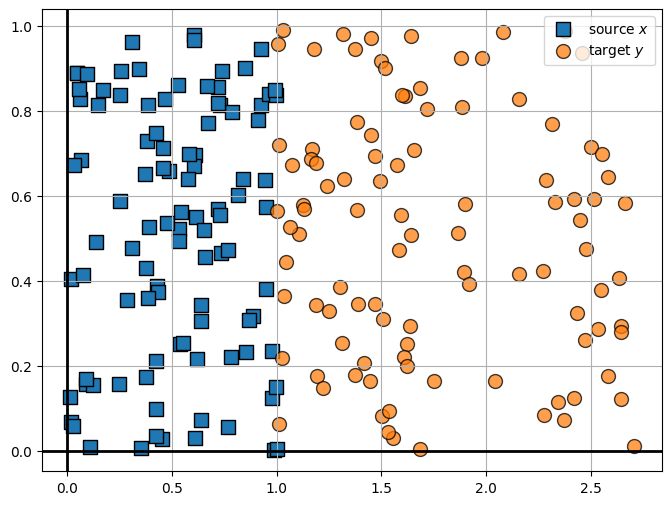

In [ ]:
x_args = {"s": 100, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
y_args = {"s": 100, "label": r"source $x$", "marker": "s", "edgecolor": "k"}
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], **y_args)
plt.scatter(Y[:, 0], Y[:, 1], **x_args)
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from ott.solvers.linear.sinkhorn import Sinkhorn

In [ ]:
def solve_sinkhorn(ticost, mu, nu, rho, epsilon, n_iter):
    # Create the OTT Sinkhorn solver object
    sinkhorn_solver = Sinkhorn(ticost)

    # Solve the optimal transport problem
    result = sinkhorn_solver(mu, nu, rho, epsilon)

    # Extract dual potentials from the result
    dual_potentials = result.dual

    return dual_potentials

In [ ]:
epsilon = 0.1  # Regularization parameter
n_iter = 100   # Number of Sinkhorn iterations
tau = 0.1
ticost = RegTICost(tau)

# Solve the optimal transport problem and get dual potentials
dual_potentials = solve_sinkhorn(ticost, X, Y, geom, epsilon, n_iter)

TypeError: Sinkhorn.__call__() takes from 2 to 4 positional arguments but 5 were given